In [32]:
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())
to_run = True
if to_run:
    os.chdir('..')
    to_run = False
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users
c:\


In [33]:
import pandas as pd
import pm4py
from pm4py.objects.dcr.obj import DcrGraph
from pm4py.objects.log.obj import EventLog, Trace
from pm4py.algo.conformance.alignments.dcr import algorithm as dcr_alignments

In [34]:
A, B, C, D, E, F, G = "A", "B", "C", "D", "E", "F", "G"

list_log = [[A, B, C, D, E, F, G],
       [A, A, A, A, A],
       [B, C, F, E, E, E, E, E, D, A, A, A, A, A, F, G],
       [B, C, A, E, F, D, G],
       [B, C, A, C, C, C, E, F, D, G],
       [B, C, A, C, F, E, D, G],
       [G],
       [E],
       [B, D, B, E, A, C, G, F],
       [F, D, C, E, A]]

log = EventLog()
for trace_list in list_log:
    trace = Trace()
    for event_name in trace_list:
        event = pm4py.objects.log.obj.Event()
        event["concept:name"] = event_name
        trace.append(event)
    log.append(trace)

In [35]:
def create_base_dcr(events):
    """
    Function for creating a dcr graph base with every event added, labels added, label_map added, and every event included

    Input: List(string)

    Returns: HierarchicalDcrGraph()
    """
    g = DcrGraph()
    for event in events:
        g.events.add(event)
        g.labels.add(event)
        g.label_map[event] = event
        g.marking.included.add(event)
    return g

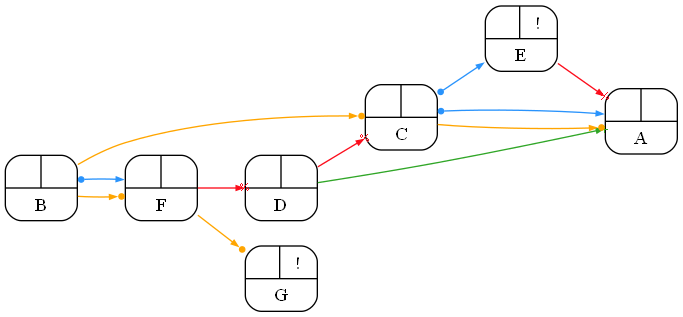

In [36]:
events = [A, B, C, D, E, F, G]
g = create_base_dcr(events)

g.excludes[E] = {A}
g.marking.pending.add(E)
g.responses[C] = {E, A}
g.conditions[A] = {C}
g.excludes[D] = {C}
g.includes[D] = {A}
g.excludes[F] = {D}
g.conditions[C] = {B}
g.conditions[F] = {B}
g.responses[B] = {F}
g.conditions[G] = {F}
g.marking.pending.add(G)

pm4py.view_dcr(g)


In [37]:
try:
    # Run allignment on the log
    alignment_results = dcr_alignments.apply(log, g, variant=dcr_alignments.Variants.OPTIMAL)
    # Fancy print statements
    print(f"{'Trace':<80} | {'Cost':<5} | {'Alignment'}")
    print("-" * 120)

    for i, result in enumerate(alignment_results):
        trace_str = str(list_log[i]) # Original trace as a string
        cost = result['cost'] # Cost from allignment
        # The alignment is a list of tuples: (Model Step, Log Step)
        # (A, A) = Sync
        # (>>, A) = Log Step (Delete)
        # (A, >>) = Model Step (Insert)
        align_steps = []
        for model_step, log_step in result['alignment']:
            if log_step == model_step:
                align_steps.append(f"SYNC({log_step})")
            elif model_step is None or model_step == ">>":
                align_steps.append(f"DELETE({log_step})")
            elif log_step is None or log_step == ">>":
                align_steps.append(f"INSERT({model_step})")
            else:
                align_steps.append(f"MISMATCH({log_step}, {model_step})")
        
        align_str = ", ".join(align_steps) # Steps joined to a single string
        print(f"{trace_str:<80} | {cost:<5} | {align_str}") # Results

except Exception as e:
    print(f"\nAn error occurred: {e}")

Trace                                                                            | Cost  | Alignment
------------------------------------------------------------------------------------------------------------------------
['A', 'B', 'C', 'D', 'E', 'F', 'G']                                              | 1     | DELETE(A), SYNC(B), SYNC(C), SYNC(D), SYNC(E), SYNC(F), SYNC(G)
['A', 'A', 'A', 'A', 'A']                                                        | 5     | INSERT(D), SYNC(A), SYNC(A), SYNC(A), SYNC(A), SYNC(A), INSERT(B), INSERT(E), INSERT(F), INSERT(G)
['B', 'C', 'F', 'E', 'E', 'E', 'E', 'E', 'D', 'A', 'A', 'A', 'A', 'A', 'F', 'G'] | 6     | SYNC(B), SYNC(C), SYNC(F), SYNC(E), SYNC(E), SYNC(E), SYNC(E), SYNC(E), DELETE(D), DELETE(A), DELETE(A), DELETE(A), DELETE(A), DELETE(A), SYNC(F), SYNC(G)
['B', 'C', 'A', 'E', 'F', 'D', 'G']                                              | 1     | SYNC(B), SYNC(C), SYNC(A), SYNC(E), SYNC(F), DELETE(D), SYNC(G)
['B', 'C', 'A', 'C', 'C', 'C', '

### Comments on results
We got the correct result for ['A', 'A', 'A', 'A', 'A'], but when we tried to run it again it got the wrong result printed out above.

The correct result is in the txt file and the report, we don't know why the result changed, as we changed nothing in the code before running it.

Also for ['B', 'C', 'F', 'E', 'E', 'E', 'E', 'E', 'D', 'A', 'A', 'A', 'A', 'A', 'F', 'G'], it never got the correct result, but at least this one is an alignment that does not break the relations of the DCR graph. But the much better allignment would have had a cost of 1 instead of 6.